# plot each lidar snow, summed sd, r2

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa

from pathlib import Path
from stats import get_stats, clean_xs_ys

from scipy.ndimage import gaussian_filter

import matplotlib as mpl
import matplotlib.pyplot as plt

from uavsar_pytools.snow_depth_inversion import depth_from_phase, phase_from_depth

# snotel lats and longs
snotel_locs = {'Dry_Creek.sd': [-116.09685, 43.76377], 'Banner.sd': [-115.23447, 44.30342], 'Mores.sd': [-115.66588, 43.932]}

# check if we are on borah or local
import socket
hn = socket.gethostname()
lidar_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar')
if hn == 'Zachs-MacBook-Pro.local':
    lidar_dir = Path('/Users/zachkeskinen/Desktop/')

# for lidar filepath
for lidar_fp in lidar_dir.glob('*.sd.nc'):
    print(lidar_fp)
    lidar = xr.open_dataset(lidar_fp)

    # single times are strings not lists
    if isinstance(lidar.attrs['lidar_times'] , str):
        lidar.attrs['lidar_times'] = [lidar.attrs['lidar_times']]
    
    # get this sites lat long for the snotel
    sntl_x, sntl_y = snotel_locs[lidar_fp.stem]
    
    # for sites with 2 lidar flights
    for t in lidar.attrs['lidar_times']:
        # make axis
        fig, axes = plt.subplots(1, 3, figsize = (12, 6))
        print(t)

        t = pd.to_datetime(t)
        # slice images that occured that year
        ds = lidar.sel(time = slice(t - pd.Timedelta('180 days'), t))
        # VV for now
        ds = ds.sel(band = 'VV')
        
        # ~0.001 degrees or ~100m
        tol = 0.00090009

        # for this years UAVSAR flight pairs
        for ds_t in ds.time:

            sub = ds.sel(time = ds_t)

            # if nans on this time slice
            if sub['232-int'].sum() == 0:
                ds['232-sd_delta_int'].loc[dict(time = ds_t)] = np.nan
                continue
            
            # if values are present
            if sub['snotel_dSWE'] > 0:
                # get current phase at the snotel
                cur_phase = sub['232-int'].sel(x = slice(sntl_x - tol, sntl_x + tol), y = slice(sntl_y + tol, sntl_y - tol)).mean()
                # get incidence angle at snotel
                sntl_inc = sub['232-inc'].sel(x = slice(sntl_x - tol, sntl_x + tol), y = slice(sntl_y + tol, sntl_y - tol)).mean()
                # get snotel from SWE change at snotel
                snotel_sd_change = sub['snotel_dSWE'] * (997 / 250)
                # calculate expected phase for this SD d
                sd_phase = phase_from_depth(snotel_sd_change, sntl_inc, density = 250)
                # invert phase -> sd delta
                data = depth_from_phase(sub['232-int'] + (sd_phase - cur_phase), sub['232-inc'], density = 250)
                # smooth with gaussian filter
                data.data = gaussian_filter(data, 3)
                # save data
                ds['232-sd_delta_int'].loc[dict(time = ds_t)] = data

            else:
                # if swe didn't increase
                ds['232-sd_delta_int'].loc[dict(time = ds_t)] = np.nan
        
        #sum sd changes through time
        sum = ds['232-sd_delta_int'].sum(dim = 'time')
        # smooth and plot lidar
        ds['lidar-sd'].loc[dict(time = t)] = gaussian_filter(ds['lidar-sd'].sel(time = t), sigma = 3)
        ds['lidar-sd'].sel(time = t).plot(ax = axes[0], vmin = 0, vmax = 3)
        # plot summed sd changes
        sum.where(~ds['lidar-sd'].sel(time = t).isnull()).plot(ax = axes[1], vmin = 0, vmax = 3)
        # remove nans, infs, and 0 s
        xs, ys = clean_xs_ys(ds['lidar-sd'].sel(time = t).values.ravel(), sum.values.ravel())
        xs_tmp = xs[(xs != 0) & (ys != 0)]
        ys = ys[(xs != 0) & (ys != 0)]
        xs = xs_tmp
        # plot 2d histogram of comparison
        axes[2].hist2d(xs, ys, bins = 100, cmap = mpl.cm.inferno, range = [[0,3.5],[0,3.5]]) # , norm = mpl.colors.LogNorm()
        # add rmse, r, n to axes 2
        rmse, r, n = get_stats(xs, ys)
        axes[2].text(.01, .99, f'RMSE: {rmse:.2}, r: {r:.2}\nn = {n:.2e}', ha='left', va='top', transform=axes[2].transAxes, color = 'white')

        for ax in axes:
            ax.set_xlabel('')
            ax.set_ylabel('')
        axes[0].set_title('Lidar Snow Depth')
        axes[1].set_title('Summed UAVSAR Snow Depth')
        plt.show()

# get r values for each gradiation

<AxesSubplot:>

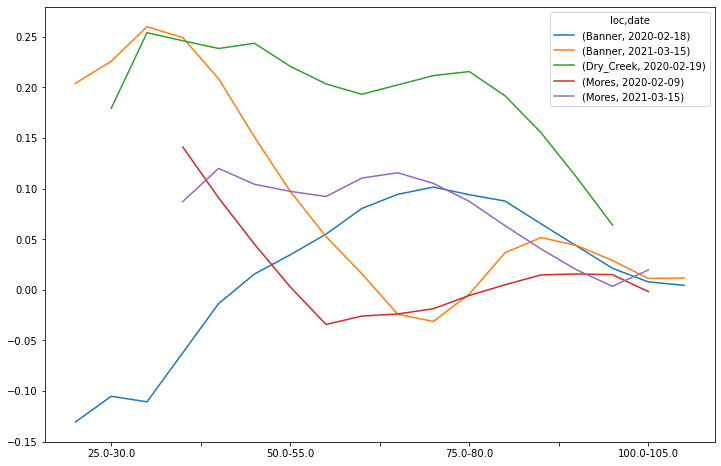

In [46]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
from tqdm import tqdm

from pathlib import Path
from stats import get_stats, clean_xs_ys

df = pd.read_csv('/Users/zachkeskinen/Documents/uavsar-validation/results/lidar-rs/inc.csv', index_col=['stat', 'loc','date'])

df.loc[('r')].T.rolling(3).mean().plot(figsize = (12,8))